# 1. Load the data and convert each session to graphs

In [2]:
import pandas as pd
import numpy as np
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [ ]:
# Load the log data

log = pd.read_csv(os.path.join(os.getcwd(),'log.csv'))

In [9]:
# Since SimGNN only takes the zero-based indexing(labels) as input, need to convert label range from 1~26 to 0~25

log['new_Labeling'] = log['Labeling']-1
log['new_prev_Labeling'] = log['prev_Labeling']-1

In [10]:
# For the use in SimGNN model, count the cumulative number of logs in each session

log['nth_label'] = log.groupby(['user_id','session'])['new_Labeling'].rank(method='dense').astype(int)-1
log['prev_nth_label'] = log['nth_label'].shift(1)

In [11]:
# Define characteristics of each node by the labels

attr1 = {}
for i in range(26):
    label = i
    attr1[i] = {'label':label}

In [12]:
# Draw graphs for each session according to the newly defined labels, ranging from 0 to 25 (Graph ver.1)

graph_dict = {}
for id, elem in tqdm(log.groupby('id')):
    data = elem['new_Labeling']
    prev_data = elem['new_prev_Labeling']
    DG = nx.DiGraph()
    DG.add_nodes_from([int(item) for item in list(data.to_numpy())])
    nx.set_node_attributes(DG,attr1)
    if elem.shape[0] > 1:
        edges = []
        for i in range(1, elem.shape[0]):
            edges.append((int(prev_data.iloc[i]),int(data.iloc[i])))
        DG.add_edges_from(edges)
    graph_dict[id] = DG

100%|█████████████████████████████████████████████████████████████████████████████| 351907/351907 [01:37<00:00, 3621.57it/s]


In [13]:
# Draw graphs for each session according to the label number within each session (Graph ver.2)

graph_dict2 = {}
for id, elem in tqdm(log.groupby('id')):
    data = elem['nth_label']
    prev_data = elem['prev_nth_label']
    DG = nx.DiGraph()
    DG.add_nodes_from([int(item) for item in list(data.to_numpy())])
    if elem.shape[0] > 1:
        edges = []
        for i in range(1, elem.shape[0]):
            edges.append((int(prev_data.iloc[i]),int(data.iloc[i])))
        DG.add_edges_from(edges)
    graph_dict2[id] = DG

100%|█████████████████████████████████████████████████████████████████████████████| 351907/351907 [01:27<00:00, 4043.91it/s]


# 2. Build the total data and training data

In [9]:
# Get node list of each graphs from graph ver.1

node_df = pd.DataFrame([graph_dict.keys(),graph_dict.values()]).transpose().rename(columns={0:'id',1:'nodes'})
node_df['nodes'] = node_df['nodes'].apply(lambda x: list(x))

In [10]:
# Get edge list of each graphs from graph ver.2

edge_df = pd.DataFrame([graph_dict2.keys(),graph_dict2.values()]).transpose().rename(columns={0:'id',1:'edges'})
edge_df['edges'] = edge_df['edges'].apply(lambda x:list(x.edges))

def tuples_to_list(x):
    for i in range(len(x)):
        x[i] = list(x[i])
    return x

edge_df['edges'] = edge_df['edges'].apply(lambda x:tuples_to_list(x))

In [ ]:
# Build node and edge list for the use in SimGNN model

node_edge_df = node_df.merge(edge_df,on=['id']).set_index('id')
node_edge_df

In [11]:
# In order to sample training data proportionally, implement simple K-Means clustering based on 2 main characteristics of each session

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(log.drop_duplicates('id')[['session_length','distinct_label_num']])

In [12]:
pd.DataFrame(kmeans.labels_).value_counts()

0    274029
3     61106
2     13873
1      2590
4       309
dtype: int64

In [ ]:
session_cluster = pd.concat([log.drop_duplicates('id')[['id','session_length','distinct_label_num']].reset_index().drop('index',axis=1),pd.DataFrame(kmeans.labels_).rename(columns={0:'label'})],axis=1)
session_cluster

In [14]:
# To build the training data, sample 100 sessions proportionally, based on the K-means clusters each session belongs to

choice_0 = list(np.random.choice(session_cluster[session_cluster['label']==0]['id'].to_numpy(),90,replace=False))
choice_1 = list(np.random.choice(session_cluster[session_cluster['label']==3]['id'].to_numpy(),6,replace=False))
choice_2 = list(np.random.choice(session_cluster[session_cluster['label']==2]['id'].to_numpy(),3,replace=False))
choice_3 = list(np.random.choice(session_cluster[session_cluster['label']==1]['id'].to_numpy(),1,replace=False))

In [ ]:
chosen_graph_df = node_edge_df.loc[choice_0+choice_1+choice_2+choice_3].reset_index()
chosen_graph_df

In [19]:
# Check if there are missing nodes in the training data that exist in the entire data

node_set = set()
for i in chosen_graph_df['nodes']:
    node_set = node_set.union(set(i))
missing_node_set = set(np.arange(26)).difference(node_set)
missing_node_set

{11, 23}

In [ ]:
# For the appropriate training of SimGNN model, we should have all 0~25 label in the training data
# If there exists the labels that did not appear at least once, randomly find the session with that label and add it to the training data

temp_node_edge_df = node_edge_df.loc[list(set(node_edge_df.index).difference(set(chosen_graph_df['id'].unique())))]
temp_node_edge_df['session_length'] = temp_node_edge_df['edges'].apply(lambda x: len(x))
temp_node_edge_df = temp_node_edge_df[temp_node_edge_df['session_length']>=chosen_graph_df['edges'].apply(lambda x: len(x)).median()]

add_id_list = []
for i in missing_node_set:
    add_id_list.append(temp_node_edge_df.loc[temp_node_edge_df[temp_node_edge_df['nodes'].apply(lambda x: i in x)==True]['session_length'].idxmin()].name)

chosen_graph_df = pd.concat([chosen_graph_df,node_edge_df.loc[add_id_list].reset_index()],axis=0).reset_index().drop('index',axis=1)
chosen_graph_df

In [21]:
# Again, check if there are missing nodes in the training data that exist in the entire data

node_set = set()
for i in chosen_graph_df['nodes']:
    node_set = node_set.union(set(i))
missing_node_set = set(np.arange(26)).difference(node_set)
missing_node_set

set()

In [23]:
# Build the training dataset

graph_pair_list = []

for i in tqdm(range(chosen_graph_df.shape[0])):
    for j in tqdm(range(chosen_graph_df.shape[0])):
        if i<j:
            graph_pair = {}
            graph_pair['labels_1'] = chosen_graph_df['nodes'].loc[i]
            graph_pair['labels_2'] = chosen_graph_df['nodes'].loc[j]
            graph_pair['graph_1'] = chosen_graph_df['edges'].loc[i]   
            graph_pair['graph_2'] = chosen_graph_df['edges'].loc[j]   
            
            graph_pair['ged'] = int(nx.graph_edit_distance(graph_dict[chosen_graph_df['id'].loc[i]], graph_dict[chosen_graph_df['id'].loc[j]]))
            graph_pair_list.append(graph_pair)
graph_pair_list

 37%|██████████████████████████▌                                             | 38/103 [00:00<00:00, 359.32it/s]


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1127.45it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1670.91it/s]

 61%|████████████████████████████████████████████▋                            | 63/103 [01:00<00:09,  4.14it/s]


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1127.61it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1161.09it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1244.49it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1776.25it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 2158.03it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1928.46it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1999.16it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 2207.96it/s]

100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:0

[{'labels_1': [4, 5, 7],
  'labels_2': [1, 24, 25, 5, 16],
  'graph_1': [[0, 1], [0, 0], [0, 2], [1, 0], [2, 1]],
  'graph_2': [[0, 3], [3, 4], [4, 1], [4, 2], [1, 4], [2, 4]],
  'ged': 5},
 {'labels_1': [4, 5, 7],
  'labels_2': [14, 1],
  'graph_1': [[0, 1], [0, 0], [0, 2], [1, 0], [2, 1]],
  'graph_2': [[1, 1], [1, 0]],
  'ged': 4},
 {'labels_1': [4, 5, 7],
  'labels_2': [0, 5],
  'graph_1': [[0, 1], [0, 0], [0, 2], [1, 0], [2, 1]],
  'graph_2': [[0, 1], [1, 0]],
  'ged': 4},
 {'labels_1': [4, 5, 7],
  'labels_2': [20, 21, 22],
  'graph_1': [[0, 1], [0, 0], [0, 2], [1, 0], [2, 1]],
  'graph_2': [[0, 0], [0, 1], [1, 1], [1, 2], [2, 1], [2, 2]],
  'ged': 1},
 {'labels_1': [4, 5, 7],
  'labels_2': [1, 24, 5, 15],
  'graph_1': [[0, 1], [0, 0], [0, 2], [1, 0], [2, 1]],
  'graph_2': [[0, 3], [3, 1], [1, 1], [1, 2], [2, 1]],
  'ged': 3},
 {'labels_1': [4, 5, 7],
  'labels_2': [1, 24, 17],
  'graph_1': [[0, 1], [0, 0], [0, 2], [1, 0], [2, 1]],
  'graph_2': [[0, 2], [2, 1], [1, 1], [1, 2]],
 

In [24]:
# Split train and validation data

train_pair_list = graph_pair_list[:len(graph_pair_list)//5 * 4]
test_pair_list = graph_pair_list[len(graph_pair_list)//5 * 4:]

In [25]:
ged_list = []
for i in train_pair_list:
    ged_list.append(i['ged'])
pd.DataFrame(ged_list).describe()

,0
count,4200.000000
mean,5.880952
std,4.604182
min,0.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,24.000000


In [26]:
# Finally check if there exists missing label in the training data

label_set = set()
for i in train_pair_list:
    label_set = label_set.union(set(i['labels_1']))
    label_set = label_set.union(set(i['labels_2']))
set(np.arange(26)).difference(label_set)

set()

# 3. Define SimGNN model

SimGNN code reference : https://github.com/benedekrozemberczki/SimGNN

In [29]:
import json
import math
from texttable import Texttable

def tab_printer(args):
    """
    Function to print the logs in a nice tabular format.
    :param args: Parameters used for the model.
    """
    args = vars(args)
    keys = sorted(args.keys())
    t = Texttable()
    t.add_rows([["Parameter", "Value"]])
    t.add_rows([[k.replace("_", " ").capitalize(), args[k]] for k in keys])
    print(t.draw())


def calculate_loss(prediction, target):
    """
    Calculating the squared loss on the normalized GED.
    :param prediction: Predicted log value of GED.
    :param target: Factual log transofmed GED.
    :return score: Squared error.
    """
    try:
        prediction = -math.log(prediction)
    except:
        prediction = np.nan
    try:
        target = -math.log(target)
    except:
        target = np.nan
    score = (prediction-target)**2
    return score

def calculate_normalized_ged(data):
    """
    Calculating the normalized GED for a pair of graphs.
    :param data: Data table.
    :return norm_ged: Normalized GED score.
    """
    norm_ged = data["ged"]/(0.5*(len(data["labels_1"])+len(data["labels_2"])))
    return norm_ged

In [30]:
import torch

class AttentionModule(torch.nn.Module):
    """
    SimGNN Attention Module to make a pass on graph.
    """
    def __init__(self, args):
        """
        :param args: Arguments object.
        """
        super(AttentionModule, self).__init__()
        self.args = args
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        """
        Defining weights.
        """
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.args.filters_3,
                                                             self.args.filters_3))

    def init_parameters(self):
        """
        Initializing weights.
        """
        torch.nn.init.xavier_uniform_(self.weight_matrix)

    def forward(self, embedding):
        """
        Making a forward propagation pass to create a graph level representation.
        :param embedding: Result of the GCN.
        :return representation: A graph level representation vector.
        """
        global_context = torch.mean(torch.matmul(embedding, self.weight_matrix), dim=0)
        transformed_global = torch.tanh(global_context)
        sigmoid_scores = torch.sigmoid(torch.mm(embedding, transformed_global.view(-1, 1)))
        representation = torch.mm(torch.t(embedding), sigmoid_scores)
        return representation

class TenorNetworkModule(torch.nn.Module):
    """
    SimGNN Tensor Network module to calculate similarity vector.
    """
    def __init__(self, args):
        """
        :param args: Arguments object.
        """
        super(TenorNetworkModule, self).__init__()
        self.args = args
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        """
        Defining weights.
        """
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.args.filters_3,
                                                             self.args.filters_3,
                                                             self.args.tensor_neurons))

        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.args.tensor_neurons,
                                                                   2*self.args.filters_3))
        self.bias = torch.nn.Parameter(torch.Tensor(self.args.tensor_neurons, 1))

    def init_parameters(self):
        """
        Initializing weights.
        """
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        """
        Making a forward propagation pass to create a similarity vector.
        :param embedding_1: Result of the 1st embedding after attention.
        :param embedding_2: Result of the 2nd embedding after attention.
        :return scores: A similarity score vector.
        """
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.args.filters_3, -1))
        scoring = scoring.view(self.args.filters_3, self.args.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores

In [31]:
import glob
import torch
import random
import numpy as np
from tqdm import tqdm, trange
from torch_geometric.nn import GCNConv

class SimGNN(torch.nn.Module):
    """
    SimGNN: A Neural Network Approach to Fast Graph Similarity Computation
    https://arxiv.org/abs/1808.05689
    """
    def __init__(self, args, number_of_labels):
        """
        :param args: Arguments object.
        :param number_of_labels: Number of node labels.
        """
        super(SimGNN, self).__init__()
        self.args = args
        self.number_labels = number_of_labels
        self.setup_layers()

    def calculate_bottleneck_features(self):
        """
        Deciding the shape of the bottleneck layer.
        """
        if self.args.histogram == True:
            self.feature_count = self.args.tensor_neurons + self.args.bins
        else:
            self.feature_count = self.args.tensor_neurons

    def setup_layers(self):
        """
        Creating the layers.
        """
        self.calculate_bottleneck_features()
        self.convolution_1 = GCNConv(self.number_labels, self.args.filters_1)
        self.convolution_2 = GCNConv(self.args.filters_1, self.args.filters_2)
        self.convolution_3 = GCNConv(self.args.filters_2, self.args.filters_3)
        self.attention = AttentionModule(self.args)
        self.tensor_network = TenorNetworkModule(self.args)
        self.fully_connected_first = torch.nn.Linear(self.feature_count,
                                                     self.args.bottle_neck_neurons)
        self.scoring_layer = torch.nn.Linear(self.args.bottle_neck_neurons, 1)

    def calculate_histogram(self, abstract_features_1, abstract_features_2):
        """
        Calculate histogram from similarity matrix.
        :param abstract_features_1: Feature matrix for graph 1.
        :param abstract_features_2: Feature matrix for graph 2.
        :return hist: Histsogram of similarity scores.
        """
        scores = torch.mm(abstract_features_1, abstract_features_2).detach()
        scores = scores.view(-1, 1)
        hist = torch.histc(scores, bins=self.args.bins)
        hist = hist/torch.sum(hist)
        hist = hist.view(1, -1)
        return hist

    def convolutional_pass(self, edge_index, features):
        """
        Making convolutional pass.
        :param edge_index: Edge indices.
        :param features: Feature matrix.
        :return features: Absstract feature matrix.
        """
        features = self.convolution_1(features, edge_index)
        features = torch.nn.functional.relu(features)
        features = torch.nn.functional.dropout(features,
                                               p=self.args.dropout,
                                               training=self.training)

        features = self.convolution_2(features, edge_index)
        features = torch.nn.functional.relu(features)
        features = torch.nn.functional.dropout(features,
                                               p=self.args.dropout,
                                               training=self.training)

        features = self.convolution_3(features, edge_index)
        return features

    def forward(self, data):
        """
        Forward pass with graphs.
        :param data: Data dictiyonary.
        :return score: Similarity score.
        """
        edge_index_1 = data["edge_index_1"]
        edge_index_2 = data["edge_index_2"]
        features_1 = data["features_1"]
        features_2 = data["features_2"]

        abstract_features_1 = self.convolutional_pass(edge_index_1, features_1)
        abstract_features_2 = self.convolutional_pass(edge_index_2, features_2)

        if self.args.histogram == True:
            hist = self.calculate_histogram(abstract_features_1,
                                            torch.t(abstract_features_2))

        pooled_features_1 = self.attention(abstract_features_1)
        pooled_features_2 = self.attention(abstract_features_2)
        scores = self.tensor_network(pooled_features_1, pooled_features_2)
        scores = torch.t(scores)

        if self.args.histogram == True:
            scores = torch.cat((scores, hist), dim=1).view(1, -1)

        scores = torch.nn.functional.relu(self.fully_connected_first(scores))
        score = torch.sigmoid(self.scoring_layer(scores))
        return score

class SimGNNTrainer(object):
    """
    SimGNN model trainer.
    """
    def __init__(self, args):
        """
        :param args: Arguments object.
        """
        self.args = args
        self.initial_label_enumeration()
        self.setup_model()

    def setup_model(self):
        """
        Creating a SimGNN.
        """
        self.model = SimGNN(self.args, self.number_of_labels)

    def initial_label_enumeration(self):
        """
        Collecting the unique node idsentifiers.
        """
        print("\nEnumerating unique labels.\n")
        self.training_graphs = self.args.training_list
        self.testing_graphs = self.args.validation_list
        if self.args.validation_option == True:
            graph_pairs = self.training_graphs + self.testing_graphs
            self.global_labels = set()
            for data in tqdm(graph_pairs):
                self.global_labels = self.global_labels.union(set(data["labels_1"]))
                self.global_labels = self.global_labels.union(set(data["labels_2"]))
            self.global_labels = sorted(self.global_labels)
            self.global_labels = {val:index  for index, val in enumerate(self.global_labels)}
            self.number_of_labels = len(self.global_labels)
        else:
            self.global_labels = [i for i in range(26)]
            self.global_labels = sorted(self.global_labels)
            self.global_labels = {val:index  for index, val in enumerate(self.global_labels)}
            self.number_of_labels = len(self.global_labels)
        
    def create_batches(self):
        """
        Creating batches from the training graph list.
        :return batches: List of lists with batches.
        """
        random.shuffle(self.training_graphs)
        batches = []
        for graph in range(0, len(self.training_graphs), self.args.batch_size):
            batches.append(self.training_graphs[graph:graph+self.args.batch_size])
        return batches

    def transfer_to_torch(self, data):
        """
        Transferring the data to torch and creating a hash table.
        Including the indices, features and target.
        :param data: Data dictionary.
        :return new_data: Dictionary of Torch Tensors.
        """
        new_data = dict()
        '''
        edges_1 = data["graph_1"] + [[y, x] for x, y in data["graph_1"]]

        edges_2 = data["graph_2"] + [[y, x] for x, y in data["graph_2"]]
        '''
        
        edges_1 = data["graph_1"]
        edges_2 = data["graph_2"]

        edges_1 = torch.from_numpy(np.array(edges_1, dtype=np.int64).T).type(torch.long)
        edges_2 = torch.from_numpy(np.array(edges_2, dtype=np.int64).T).type(torch.long)

        features_1, features_2 = [], []

        for n in data["labels_1"]:
            features_1.append([1.0 if self.global_labels[n] == i else 0.0 for i in self.global_labels.values()])

        for n in data["labels_2"]:
            features_2.append([1.0 if self.global_labels[n] == i else 0.0 for i in self.global_labels.values()])

        features_1 = torch.FloatTensor(np.array(features_1))
        features_2 = torch.FloatTensor(np.array(features_2))

        new_data["edge_index_1"] = edges_1
        new_data["edge_index_2"] = edges_2

        new_data["features_1"] = features_1
        new_data["features_2"] = features_2

        norm_ged = data["ged"]/(0.5*(len(data["labels_1"])+len(data["labels_2"])))

        new_data["target"] = torch.from_numpy(np.exp(-norm_ged).reshape(1, 1)).view(-1).float()
        return new_data


    def process_batch(self, batch):
        """
        Forward pass with a batch of data.
        :param batch: Batch of graph pair locations.
        :return loss: Loss on the batch.
        """
        self.optimizer.zero_grad()
        losses = 0
        for data in batch:
            data = self.transfer_to_torch(data)
            target = data["target"]
            prediction = self.model(data)
            losses = losses + torch.nn.functional.mse_loss(data["target"], prediction)
        losses.backward(retain_graph=True)
        self.optimizer.step()
        loss = losses.item()
        return loss

    def fit(self):
        """
        Fitting a model.
        """
        print("\nModel training.\n")

        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=self.args.learning_rate,
                                          weight_decay=self.args.weight_decay)

        self.model.train()
        epochs = trange(self.args.epochs, leave=True, desc="Epoch")
        for epoch in epochs:
            batches = self.create_batches()
            self.loss_sum = 0
            main_index = 0
            for index, batch in tqdm(enumerate(batches), total=len(batches), desc="Batches"):
                loss_score = self.process_batch(batch)
                main_index = main_index + len(batch)
                self.loss_sum = self.loss_sum + loss_score * len(batch)
                loss = self.loss_sum/main_index
                epochs.set_description("Epoch (Loss=%g)" % round(loss, 5))

    def score(self):
        """
        Scoring on the test set.
        """
        print("\n\nModel evaluation.\n")
        self.model.eval()
        self.scores = []
        self.ground_truth = []
        self.preds = []
        self.targets = []
        
        if self.args.validation_option == True: 
            for data in tqdm(self.testing_graphs):
                self.ground_truth.append(calculate_normalized_ged(data))
                data = self.transfer_to_torch(data)
                target = data["target"]
                prediction = self.model(data)
                self.scores.append(calculate_loss(prediction, target))
                self.preds.append(prediction)
                self.targets.append(target)
            self.print_evaluation()
            return self.preds,self.targets

        else:
            for data in tqdm(self.testing_graphs):
                self.ground_truth.append(calculate_normalized_ged(data))
                data = self.transfer_to_torch(data)
                target = data["target"]
                prediction = self.model(data)
                self.scores.append(calculate_loss(prediction, target))
                self.preds.append(prediction)
                self.targets.append(target)
            self.print_evaluation()
            return self.preds
        
    def print_evaluation(self):
        """
        Printing the error rates.
        """
        norm_ged_mean = np.mean(self.ground_truth)
        base_error = np.mean([(n-norm_ged_mean)**2 for n in self.ground_truth])
        model_error = np.mean(self.scores)
        print("\nBaseline error: " +str(round(base_error, 5))+".")
        print("\nModel test error: " +str(round(model_error, 5))+".")

    def save(self):
        torch.save(self.model.state_dict(), self.args.save_path)

    def load(self):
        self.model.load_state_dict(torch.load(self.args.load_path))

# 4. Train and validate SimGNN model

## 4.1. SimGNN train

In [72]:
# Enter the hyperparameter parsers for the training of SimGNN

import argparse

def parameter_parser():
    """
    A method to parse up command line parameters.
    The default hyperparameters give a high performance model without grid search.
    """
    parser = argparse.ArgumentParser(description="Run SimGNN.")

    parser.add_argument("--training_list",
                        default=train_pair_list)
    
    parser.add_argument("--validation_list",
                        default=test_pair_list)    

    parser.add_argument("--validation_option",
                        default=False)    

    parser.add_argument("--entire_data",
                        default=log)
    
    parser.add_argument("--entire_df",
                        default=node_edge_df.reset_index())
    
    parser.add_argument("--epochs",
                        type=int,
                        default=5,
	                help="Number of training epochs. Default is 5.")

    parser.add_argument("--filters-1",
                        type=int,
                        default=60,
	                help="Filters (neurons) in 1st convolution. Default is 128.")

    parser.add_argument("--filters-2",
                        type=int,
                        default=40,
	                help="Filters (neurons) in 2nd convolution. Default is 64.")

    parser.add_argument("--filters-3",
                        type=int,
                        default=20,
	                help="Filters (neurons) in 3rd convolution. Default is 32.")

    parser.add_argument("--tensor-neurons",
                        type=int,
                        default=12,
	                help="Neurons in tensor network layer. Default is 16.")

    parser.add_argument("--bottle-neck-neurons",
                        type=int,
                        default=12,
	                help="Bottle neck layer neurons. Default is 16.")

    parser.add_argument("--batch-size",
                        type=int,
                        default=100,
	                help="Number of graph pairs per batch. Default is 128.")

    parser.add_argument("--bins",
                        type=int,
                        default=12,
	                help="Similarity score bins. Default is 16.")

    parser.add_argument("--dropout",
                        type=float,
                        default=0.1,
	                help="Dropout probability. Default is 0.5.")

    parser.add_argument("--learning-rate",
                        type=float,
                        default=0.01,
	                help="Learning rate. Default is 0.001.")

    parser.add_argument("--weight-decay",
                        type=float,
                        default=5*10**-4,
	                help="Adam weight decay. Default is 5*10^-4.")

    parser.add_argument("--histogram",
                        dest="histogram",
                        action="store_true")

    parser.set_defaults(histogram=True)

    parser.add_argument("--save-path",
                        type=str,
                        default= os.path.join(os.getcwd(),'simgnn_by_label.pth'),
                        help="Where to save the trained model")

    parser.add_argument("--load-path",
                        type=str,
                        default=None,
                        help="Load a pretrained model")

    return parser.parse_args(args=[])

In [106]:
# Train SimGNN model

args = parameter_parser()
trainer = SimGNNTrainer(args)
if args.load_path:
    trainer.load()
else:
    trainer.fit()
    trainer.score()
if args.save_path:
    trainer.save()


Enumerating unique labels.


Model training.



Batches:   0%|                                                                          | 0/42 [00:00<?, ?it/s]/tmp/ipykernel_1370/688282479.py:218: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses = losses + torch.nn.functional.mse_loss(data["target"], prediction)
Epoch (Loss=1.90874):  60%|███████████████████████████████▊                     | 3/5 [07:01<04:29, 134.87s/it]


Epoch (Loss=1.50101): 100%|█████████████████████████████████████████████████████| 5/5 [11:14<00:00, 134.94s/it]




Model evaluation.



100%|█████████████████████████████████████████████████████████████████████| 1031/1031 [00:02<00:00, 353.00it/s]


Baseline error: 1.49454e+00.

Model test error: 0.66325.


## 4.2. SimGNN validation

In [ ]:
# Enter hyperparameter parsers for the prediction and GED computation using SimGNN

import argparse

def parameter_parser():
    """
    A method to parse up command line parameters.
    The default hyperparameters give a high performance model without grid search.
    """
    parser = argparse.ArgumentParser(description="Run SimGNN.")

    parser.add_argument("--training_list",
                        default=train_pair_list)
    
    parser.add_argument("--validation_list",
                        default=test_pair_list)    

    parser.add_argument("--validation_option",
                        default=True)    

    parser.add_argument("--entire_data",
                        default=log)
    
    parser.add_argument("--entire_df",
                        default=node_edge_df.reset_index())
    
    parser.add_argument("--epochs",
                        type=int,
                        default=5,
	                help="Number of training epochs. Default is 5.")

    parser.add_argument("--filters-1",
                        type=int,
                        default=60,
	                help="Filters (neurons) in 1st convolution. Default is 128.")

    parser.add_argument("--filters-2",
                        type=int,
                        default=40,
	                help="Filters (neurons) in 2nd convolution. Default is 64.")

    parser.add_argument("--filters-3",
                        type=int,
                        default=20,
	                help="Filters (neurons) in 3rd convolution. Default is 32.")

    parser.add_argument("--tensor-neurons",
                        type=int,
                        default=12,
	                help="Neurons in tensor network layer. Default is 16.")

    parser.add_argument("--bottle-neck-neurons",
                        type=int,
                        default=12,
	                help="Bottle neck layer neurons. Default is 16.")

    parser.add_argument("--batch-size",
                        type=int,
                        default=100,
	                help="Number of graph pairs per batch. Default is 128.")

    parser.add_argument("--bins",
                        type=int,
                        default=12,
	                help="Similarity score bins. Default is 16.")

    parser.add_argument("--dropout",
                        type=float,
                        default=0.1,
	                help="Dropout probability. Default is 0.5.")

    parser.add_argument("--learning-rate",
                        type=float,
                        default=0.01,
	                help="Learning rate. Default is 0.001.")

    parser.add_argument("--weight-decay",
                        type=float,
                        default=5*10**-4,
	                help="Adam weight decay. Default is 5*10^-4.")

    parser.add_argument("--histogram",
                        dest="histogram",
                        action="store_true")

    parser.set_defaults(histogram=True)

    parser.add_argument("--save-path",
                        type=str,
                        default= os.path.join(os.getcwd(),'simgnn_by_label.pth'),
                        help="Where to save the trained model")

    parser.add_argument("--load-path",
                        type=str,
                        default= os.path.join(os.getcwd(),'simgnn_by_label.pth'),
                        help="Load a pretrained model")

    return parser.parse_args(args=[])

In [108]:
# SimGNN model validation

args = parameter_parser()
trainer = SimGNNTrainer(args)
trainer.load()
pred,real = trainer.score()


Enumerating unique labels.



100%|██████████████████████████████████████████████████████████████████| 5151/5151 [00:00<00:00, 669752.00it/s]




Model evaluation.



100%|█████████████████████████████████████████████████████████████████████| 1031/1031 [00:02<00:00, 347.32it/s]


Baseline error: 1.49454e+00.

Model test error: 0.21887.


In [109]:
pred = [i.item() for i in pred]
real = [i.item() for i in real]

In [110]:
# Correlation between normalized_ged predicted by SimGNN, and the actual normalized_ged on the validation set

test_result = pd.DataFrame([pred,real]).transpose().rename(columns={0:'pred',1:'real'})
test_result.corr()

,pred,real
pred,1.0000,0.8533
real,0.8533,1.0000


In [111]:
test_result

,pred,real
0,0.428859,0.513417
1,0.308967,0.318907
2,0.269572,0.449329
3,0.306704,0.318907
4,0.207132,0.263597
...,...,...
1026,0.029468,0.027324
1027,0.002020,0.004087
1028,0.242646,0.162321
1029,0.277476,0.101701


In [112]:
test_result_df = pd.concat([test_result,pd.DataFrame(test_pair_list)],axis=1)
test_result_df['pred_orig'] = -np.log(test_result_df['pred'])*(test_result_df['labels_1'].apply(lambda x: len(x))+test_result_df['labels_2'].apply(lambda x: len(x)))*0.5
test_result_df['real_orig'] = -np.log(test_result_df['real'])*(test_result_df['labels_1'].apply(lambda x: len(x))+test_result_df['labels_2'].apply(lambda x: len(x)))*0.5

In [113]:
# Correlation between GED predicted by SimGNN, and the actual GED on the validation set

test_result_df[['pred_orig','real_orig']].corr()

,pred_orig,real_orig
pred_orig,1.000000,0.975396
real_orig,0.975396,1.000000


In [157]:
# Sessions that were predicted to have GED less than or equal to 2 by SimGNN indeed had actual GED less than or equal to 2

test_result_df[test_result_df['pred_orig']<=2]['real_orig'].quantile(0.8)

2.0000000311837107

In [158]:
test_result_df[test_result_df['real_orig']<=2]['pred_orig'].quantile(0.8)

2.4674226808703335

# 5. Extract graph embeddings from the trained SimGNN

In [ ]:
# Enter hyperparameter parsers for the prediction and GED computation using SimGNN

import argparse

def parameter_parser():
    """
    A method to parse up command line parameters.
    The default hyperparameters give a high performance model without grid search.
    """
    parser = argparse.ArgumentParser(description="Run SimGNN.")

    parser.add_argument("--training_list",
                        default=hard_pair_list1)
    
    parser.add_argument("--validation_list",
                        default=hard_pair_list1)    

    parser.add_argument("--validation_option",
                        default=False)    

    parser.add_argument("--entire_data",
                        default=log)
    
    parser.add_argument("--entire_df",
                        default=node_edge_df.reset_index())
    
    parser.add_argument("--epochs",
                        type=int,
                        default=5,
	                help="Number of training epochs. Default is 5.")

    parser.add_argument("--filters-1",
                        type=int,
                        default=60,
	                help="Filters (neurons) in 1st convolution. Default is 128.")

    parser.add_argument("--filters-2",
                        type=int,
                        default=40,
	                help="Filters (neurons) in 2nd convolution. Default is 64.")

    parser.add_argument("--filters-3",
                        type=int,
                        default=20,
	                help="Filters (neurons) in 3rd convolution. Default is 32.")

    parser.add_argument("--tensor-neurons",
                        type=int,
                        default=12,
	                help="Neurons in tensor network layer. Default is 16.")

    parser.add_argument("--bottle-neck-neurons",
                        type=int,
                        default=12,
	                help="Bottle neck layer neurons. Default is 16.")

    parser.add_argument("--batch-size",
                        type=int,
                        default=100,
	                help="Number of graph pairs per batch. Default is 128.")

    parser.add_argument("--bins",
                        type=int,
                        default=12,
	                help="Similarity score bins. Default is 16.")

    parser.add_argument("--dropout",
                        type=float,
                        default=0.1,
	                help="Dropout probability. Default is 0.5.")

    parser.add_argument("--learning-rate",
                        type=float,
                        default=0.01,
	                help="Learning rate. Default is 0.001.")

    parser.add_argument("--weight-decay",
                        type=float,
                        default=5*10**-4,
	                help="Adam weight decay. Default is 5*10^-4.")

    parser.add_argument("--histogram",
                        dest="histogram",
                        action="store_true")

    parser.set_defaults(histogram=True)

    parser.add_argument("--save-path",
                        type=str,
                        default= os.path.join(os.getcwd(),'simgnn_by_label.pth'),
                        help="Where to save the trained model")

    parser.add_argument("--load-path",
                        type=str,
                        default= os.path.join(os.getcwd(),'simgnn_by_label.pth'),
                        help="Load a pretrained model")

    return parser.parse_args(args=[])

In [32]:
node_edge_df2 = node_edge_df.reset_index()

In [33]:
pivot_graph_id = node_edge_df2.loc[node_edge_df2['edges'].apply(lambda x: len(x)).idxmin()]['id']

In [ ]:
import ast
pivot_label = node_edge_df2[node_edge_df2['id']==pivot_graph_id]['nodes'].iloc[0]
pivot_edges = node_edge_df2[node_edge_df2['id']==pivot_graph_id]['edges'].iloc[0]

hard_pair_df1 = pd.DataFrame(node_edge_df2['nodes']).rename(columns={'nodes':'labels_2'})
hard_pair_df1['labels_1'] = str(pivot_label)
hard_pair_df1['graph_1'] = str(pivot_edges)
hard_pair_df1['graph_2'] = node_edge_df2['edges']
hard_pair_df1['ged'] = 0

hard_pair_df1['labels_1'] = hard_pair_df1['labels_1'].apply(lambda x:ast.literal_eval(x))
hard_pair_df1['graph_1'] = hard_pair_df1['graph_1'].apply(lambda x:ast.literal_eval(x))
hard_pair_df1

In [35]:
hard_pair_list1 = list(hard_pair_df1.transpose().to_dict().values())

In [96]:
temp = SimGNNTrainer(parameter_parser())
model = SimGNN(parameter_parser(), 26)
model.load_state_dict(torch.load(os.path.join(os.getcwd(),'simgnn_by_label.pth')))

embedding_list = []
for i in tqdm(range(node_edge_df2.shape[0])):
    data = temp.transfer_to_torch(hard_pair_list1[i])
    edge_index_2 = data["edge_index_2"]
    features_2 = data["features_2"]
    abstract_features_2 = model.convolutional_pass(edge_index_2, features_2)
    pooled_features_2 = model.attention(abstract_features_2)
    array_2 = list(pd.DataFrame(pooled_features_2.detach()).transpose().to_numpy()[0])
    embedding_list.append(array_2)


Enumerating unique labels.



100%|██████████████████████████████████████████████████████████████████████████████| 351907/351907 [11:05<00:00, 528.59it/s]


In [106]:
embedding_df = pd.concat([pd.DataFrame(node_edge_df.index),pd.DataFrame(embedding_list)],axis=1).set_index('id')

In [178]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,kmeans_label
id,,,,,,,,,,,,,,,,,,,,,
U10001_0,0.016655,0.294953,-0.019916,-0.075573,-0.093100,0.141136,-0.051809,-0.012392,0.064054,-0.390225,...,0.352738,-0.113277,0.036902,0.166697,-0.009783,-0.131396,-0.007377,-0.479243,-0.025357,5
U10001_1,0.165537,0.689439,0.145124,-0.359217,-0.248507,0.402924,-0.008962,-0.018755,0.179150,-1.449610,...,1.057907,-0.387773,0.373650,0.390690,0.001414,-0.471435,-0.107598,-1.301355,-0.211710,2
U10001_11,0.028009,0.296313,-0.022448,-0.061944,-0.048589,0.179725,-0.032958,0.021578,0.042253,-0.433374,...,0.398244,-0.079964,0.104147,0.167392,0.038883,-0.146819,-0.008227,-0.468244,-0.025858,5
U10001_12,-0.024151,1.027364,0.054278,-0.238131,-0.157720,0.385590,-0.123074,0.016129,0.117033,-1.324889,...,1.326986,-0.390480,0.349799,0.606135,0.011866,-0.390845,0.076145,-1.265777,-0.059068,2
U10001_2,0.182492,0.632208,0.174587,-0.247770,-0.182612,0.284967,0.087635,0.015853,-0.044466,-1.583591,...,1.288892,-0.272520,0.504257,0.536045,0.047050,-0.496177,-0.077446,-1.013002,-0.108070,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U15000_54,0.024946,0.351934,0.020911,-0.052156,-0.056431,0.130631,-0.061288,0.024568,-0.023610,-0.457673,...,0.481317,-0.037622,0.125498,0.171264,0.016098,-0.147585,-0.001077,-0.382383,-0.026997,15
U15000_55,0.157875,0.524918,0.162683,-0.185123,-0.141665,0.290783,0.063028,0.036100,-0.048222,-1.364007,...,1.118857,-0.268686,0.419317,0.399286,0.108042,-0.439246,-0.092572,-0.897248,-0.089581,9
U15000_57,0.029783,0.286347,0.008802,-0.207014,-0.183036,0.143441,-0.053187,-0.023808,-0.111495,-0.815759,...,0.687316,-0.108708,0.258088,0.222176,0.065406,-0.274862,-0.116984,-0.611518,-0.088799,10


# 6. Clustering the graph embeddings

## 6.1. K-means clustering

In [8]:
# Cluster the 20-dimensional graph embeddings into 20 clusters using K-means

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(embedding_df)
embedding_df['kmeans_label'] = kmeans.labels_

In [116]:
embedding_df['kmeans_label'].value_counts()

10    45190
0     42097
5     41260
15    40608
9     20804
14    20358
7     19945
3     18633
11    16807
12    14571
13    12531
2     11579
8     11227
1      9949
6      6276
17     5688
16     5173
19     5073
18     3159
4       979
Name: kmeans_label, dtype: int64

In [187]:
embedding_df.to_csv(os.path.join(os.getcwd(),'embedding_cluster_by_label.csv'))

In [5]:
embedding_df = pd.read_csv(os.path.join(os.getcwd(),'embedding_cluster_by_label.csv'))
embedding_df = embedding_df.set_index('id').drop('id.1',axis=1)

## 6.2. Determining the optimal number of clusters

100%|███████████████████████████████████████████████████████████████████████████████████████| 26/26 [02:17<00:00,  5.28s/it]


(array([15000., 20000., 25000., 30000., 35000., 40000., 45000., 50000.,
        55000., 60000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

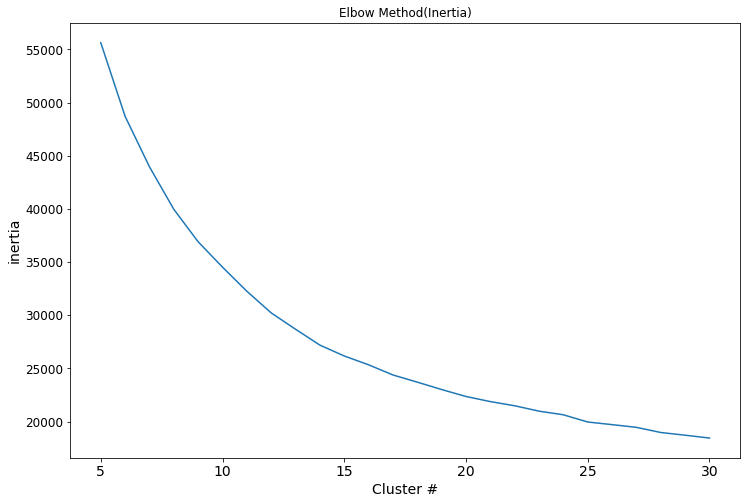

In [19]:
# Determine the optimal number of K-means clusters based on the elbow method

from sklearn.cluster import KMeans

inertia_list = []
for i in tqdm(range(5,31)):
    kmeans = KMeans(n_clusters=i).fit(embedding_df.drop('kmeans_label',axis=1))
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(np.arange(5,31), inertia_list)
plt.title('Elbow Method(Inertia)')
plt.xlabel('Cluster #',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('inertia',fontsize=14)
plt.yticks(fontsize=12)

100%|███████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]


(array([0.22, 0.24, 0.26, 0.28, 0.3 , 0.32]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

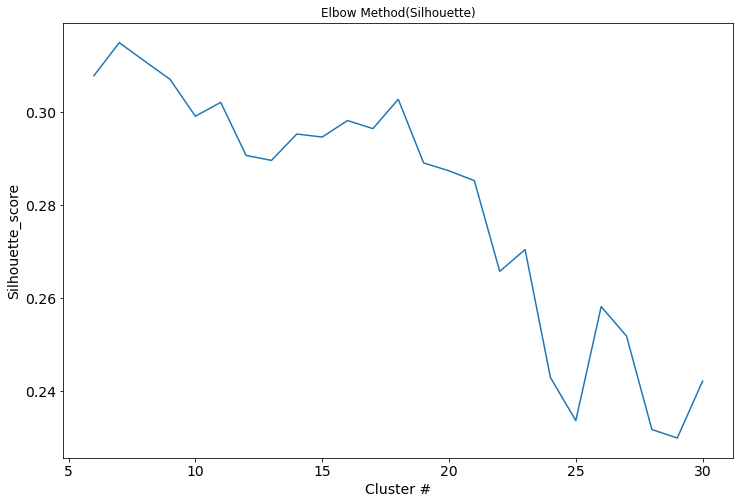

In [20]:
# Determine the optimal number of K-means clusters based on the silhouette coefficient

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_list = []
for i in tqdm(range(6,31)):
    kmeans = KMeans(n_clusters=i, random_state=2022).fit(embedding_df.drop('kmeans_label',axis=1).iloc[:10000])
    silhouette_list.append(silhouette_score(embedding_df.drop('kmeans_label',axis=1).iloc[:10000],kmeans.labels_))

plt.figure(figsize=(12,8))
plt.plot(np.arange(6,31), silhouette_list)
plt.title('Elbow Method(Silhouette)')
plt.xlabel('Cluster #',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Silhouette_score',fontsize=14)
plt.yticks(fontsize=14)

# 8. Visualization of each embedding clusters

In [ ]:
cluster_count = pd.DataFrame(embedding_df['kmeans_label'].value_counts())
cluster_count[cluster_count['kmeans_label']>=embedding_df.shape[0]*0.01]

In [22]:
sample_id_dict = dict()
for cluster, data in embedding_df.groupby(['kmeans_label']):
    sample_id = np.random.choice(embedding_df.index,1)[0]
    sample_id_dict[cluster] = sample_id

In [56]:
cluster_count.loc[10][0]

45190

In [ ]:
plt.figure(figsize = (40,40))
plt.suptitle('Representative graphs of 20 clusters',fontsize=14)
for i in range(20):
    plt.subplot(4,5,i+1)
    color='blue'
    nx.draw(graph_dict[sample_id_dict[cluster_count.index[i]]],node_size=1000,node_color=color)    
    plt.title(f'Top {i+1}th cluster: Cluster_{int(cluster_count.index[i])} (n={cluster_count.loc[i][0]})',fontsize=12)
    plt.subplots_adjust(wspace=1)
    
plt.show()